In [1]:
import pandas as pd
import numpy as np
import itertools as it
import functools as ft
import multiprocessing as mp

from sklearn.model_selection import GridSearchCV
from sklearn.model_selection import KFold
from sklearn.ensemble import BaggingClassifier
from sklearn.linear_model import SGDClassifier
from sklearn.linear_model.coordinate_descent import LinearModelCV
from sklearn.linear_model import ElasticNetCV
from sklearn.base import RegressorMixin
from sklearn.model_selection import cross_validate
from sklearn.metrics import *

from tools import helpers as h

from scipy.stats import norm

%matplotlib inline
import matplotlib.pyplot as plt

In [2]:
louv = pd.read_csv('../results/networkClusters/louvain_small_clusters.txt', sep='\t', index_col=0)
rand = pd.read_csv('../results/sensitivityNetworkClusters/sensitivity_randscores.tsv', sep='\t')
rand.index=louv.index
rand.columns = louv.index.values

In [3]:
from umap import UMAP
import seaborn as sns
sns.set()

In [4]:
u = UMAP(metric='cosine', n_neighbors=5, min_dist=.01)
u_coords = u.fit_transform(rand.values)

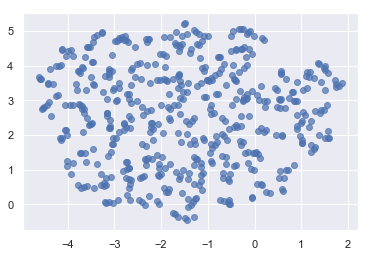

In [5]:
plt.scatter(u_coords[:, 0], u_coords[:, 1], alpha=0.7)
plt.show()

In [6]:
sns.set_style('ticks')

In [31]:
# frequency of identical
np.sum((rand==1).sum())/(517**2)

0.5582197546475912

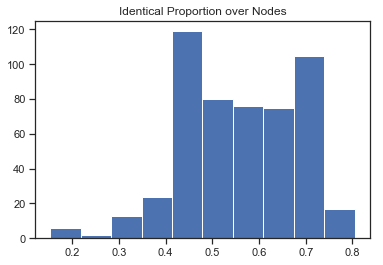

In [35]:
plt.hist((rand==1).sum()/517.)
plt.title('Identical Proportion over Nodes')
plt.show()

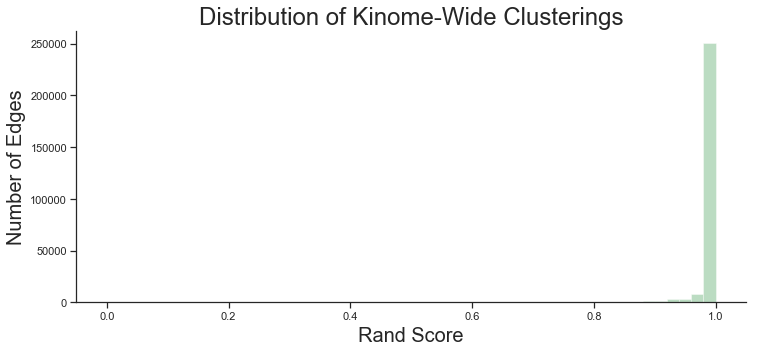

In [50]:
fig, ax = plt.subplots(figsize=(12,5))
sns.distplot(rand.values.flatten(), kde=False, color='g')
#ax.set_title('')
plt.title('Distribution of Kinome-Wide Clusterings', size=24)
plt.ylabel('Number of Edges', size=20)
plt.xlabel('Rand Score', size=20) 
sns.despine()
plt.show()

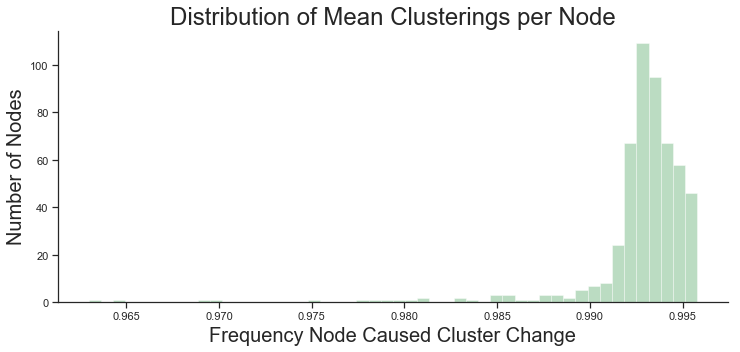

In [47]:
fig, ax = plt.subplots(figsize=(12,5))
sns.distplot(rand.mean(axis=1), kde=False, color='g')
#ax.set_title('')
plt.title('Distribution of Mean Clusterings per Node', size=24)
plt.ylabel('Number of Nodes', size=20)
plt.xlabel('Frequency Node Caused Cluster Change', size=20) 
sns.despine()
plt.show()

In [36]:
mean_nonzero = np.mean(rand[rand !=1], axis=1)
nonzero_count = np.sum((rand != 1).values, axis=1)

In [26]:
network = pd.read_csv('../data/interactionNetworks/kin_anscombe_weighted.csv', sep='\t', header=None)
network.head()

,0,1,2
0,MST1R,YES1,1.224745
1,TYRO3,YES1,1.224745
2,FGR,SRC,2.345208
3,ATR,FLT1,1.224745
4,LYN,PRKCD,3.082207


In [37]:
nodelist = pd.DataFrame(pd.concat([network.iloc[:, 0], network.iloc[:, 1]], axis=0, ignore_index=True))
nodelist.columns = ['Node']
nodelist['Degree'] = ''
degree = nodelist.groupby('Node').agg(len)

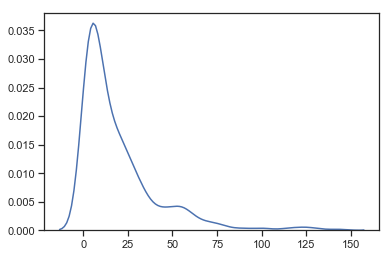

In [38]:
sns.kdeplot(degree.values[:, 0])
plt.show()

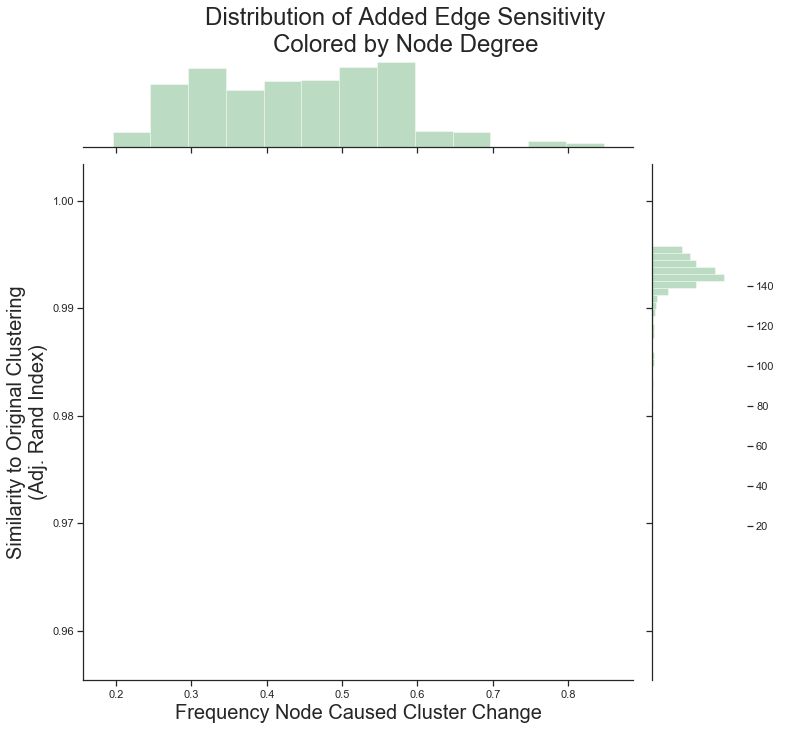

In [97]:
g = sns.jointplot(nonzero_count/517., rand.mean(axis=0), color='g', height=10, kind='scatter', alpha=0)
points = g.ax_joint.scatter(nonzero_count/517., rand.mean(axis=0), c=degree.loc[louv.index].values[:, 0], cmap='viridis_r', alpha=0)
g.ax_joint.set_ylabel('Similarity to Original Clustering\n(Adj. Rand Index)', size=20)
g.ax_joint.set_xlabel('Frequency Node Caused Cluster Change', size=20)

plt.subplots_adjust(top=0.91)
g.fig.suptitle('Distribution of Added Edge Sensitivity\nColored by Node Degree', size=24)

cbar = plt.colorbar(points)
cbar.outline.set_visible(False)
#cbar.ax.axes.set_visible(False)
cbar.ax.get_yaxis().labelpad = 15
cbar.ax.set_ylabel('Node Degree', rotation=270, fontsize=20, color='white')

plt.show()

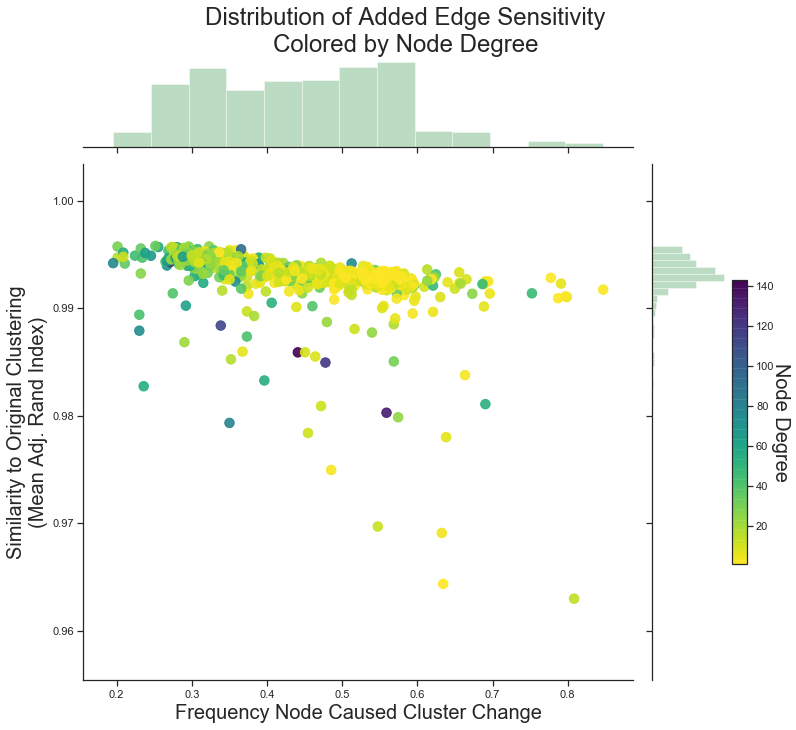

In [99]:
g = sns.jointplot(nonzero_count/517., rand.mean(axis=0), color='g', height=10, kind='scatter', alpha=0)
points = g.ax_joint.scatter(nonzero_count/517., rand.mean(axis=0), c=degree.loc[louv.index].values[:, 0], cmap='viridis_r', alpha=0.9, s=90)
g.ax_joint.set_ylabel('Similarity to Original Clustering\n(Mean Adj. Rand Index)', size=20)
g.ax_joint.set_xlabel('Frequency Node Caused Cluster Change', size=20)

plt.subplots_adjust(top=0.91)
g.fig.suptitle('Distribution of Added Edge Sensitivity\nColored by Node Degree', size=24)

cbar = plt.colorbar(points)
cbar.ax.get_yaxis().labelpad = 15
cbar.ax.set_ylabel('Node Degree', rotation=270, fontsize=20)

plt.show()

In [51]:
dark = pd.read_csv('../data/miscReference/dark_kinases.csv')
dark.head()

,hgnc_id,symbol,ensembl_gene_id,class,name,uniprot_ids,kinase_com_name
0,HGNC:19038,ADCK1,ENSG00000063761,Dark,aarF domain containing kinase 1,Q86TW2,ADCK1
1,HGNC:19039,ADCK2,ENSG00000133597,Dark,aarF domain containing kinase 2,Q7Z695,ADCK2
2,HGNC:21738,ADCK5,ENSG00000173137,Dark,aarF domain containing kinase 5,Q3MIX3,ADCK5
3,HGNC:20565,ALPK2,ENSG00000198796,Dark,alpha kinase 2,Q86TB3,AlphaK2
4,HGNC:17574,ALPK3,ENSG00000136383,Dark,alpha kinase 3,Q96L96,AlphaK1


In [52]:
import matplotlib.cm as cm

In [53]:
prgn = cm.get_cmap('PRGn')


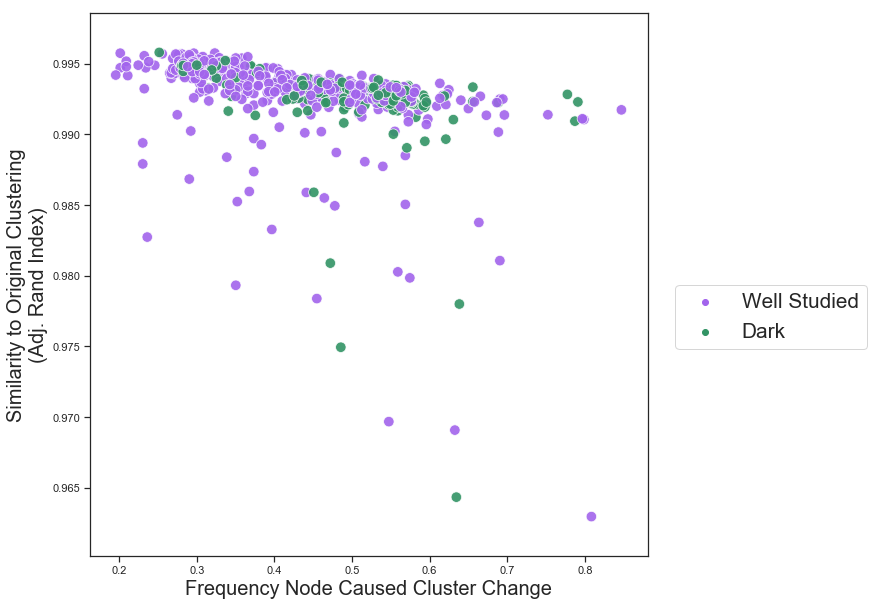

In [100]:
l = louv.merge(dark[['symbol', 'class']], left_index=True, right_on='symbol', how='left')
fig, ax = plt.subplots(figsize=(10,10))
g = sns.scatterplot(nonzero_count/517., rand.mean(axis=0), ax=ax, hue=(l['class'].fillna('Well Studied')).values, alpha=.9, s=110,
                   palette=sns.diverging_palette(280, 145, s=85, l=55, n=2))
g.set_ylabel('Similarity to Original Clustering\n(Adj. Rand Index)', size=20)
g.set_xlabel('Frequency Node Caused Cluster Change', size=20)
 
#plt.setp(ax.get_legend().get_texts(), fontsize='26') 
#plt.legend(loc='lower left')
plt.legend(bbox_to_anchor=(1.05, .5), loc=2, borderaxespad=0., fontsize='xx-large')
#sns.fig.legend
plt.show()

In [55]:
color = pd.read_csv('../results/networkClusters/louvain_clusters.txt', sep='\t')
color.head()

,names,cluster
0,MST1R,3
1,YES1,3
2,TYRO3,3
3,FGR,3
4,SRC,3


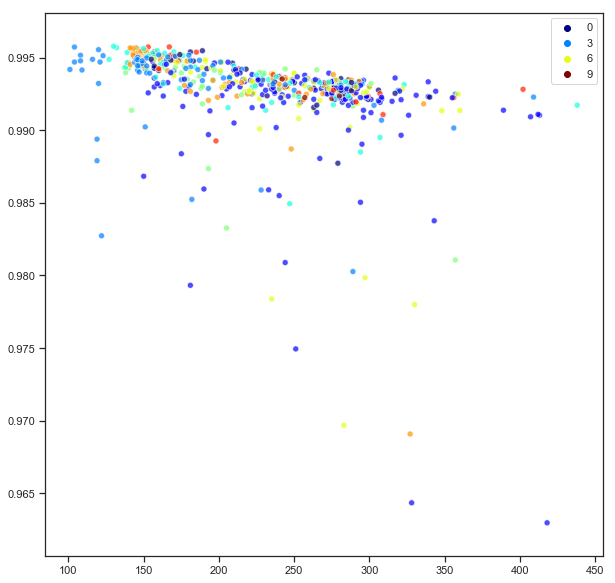

In [101]:
fig, ax = plt.subplots(figsize=(10,10))
sns.scatterplot(nonzero_count, rand.mean(axis=0), ax=ax, hue=color['cluster'].values, palette='jet', alpha=0.7)
plt.show()

### Individual sensitivity Analysis

In [96]:
# these are the kinases with the largest change 
low_rand_ids = rand.mean(axis=0)[rand.mean(axis=0) < 0.95].index.tolist()

display(louv.loc[low_rand_ids])

,cluster
names,


In [102]:
rand[rand > 0].min(axis=0).min(axis=0)

0.628465242149574

In [103]:
np.where(rand == rand[rand > 0].min(axis=0).min(axis=0))

(array([  3, 131]), array([131,   3]))

In [60]:
# find the minimal edge
(rand.index[3], rand.index[131])

('FGR', 'PDK2')

0.628465242149574
PDK2


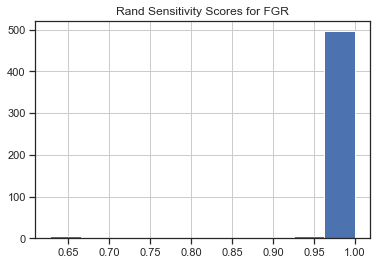

In [104]:
rand_fgr = rand.loc['FGR']
print(rand_fgr[rand_fgr > 0].min())
print(rand_fgr[rand_fgr > 0].idxmin())

rand_fgr[rand_fgr > 0].hist()
plt.title('Rand Sensitivity Scores for FGR')
plt.show()


0.628465242149574
FGR


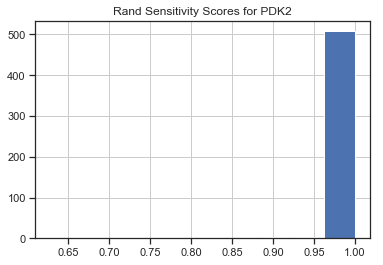

In [63]:
rand_pdk2 = rand.loc['PDK2']
print(rand_pdk2[rand_pdk2 > 0].min())
print(rand_pdk2[rand_pdk2 > 0].idxmin())

rand_pdk2[rand_pdk2 > 0].hist()
plt.title('Rand Sensitivity Scores for PDK2')
plt.show()

In [64]:
rand[rand > 0].min(axis=0).idxmin(axis=0)

'FGR'

0.6591502878194301
TEC


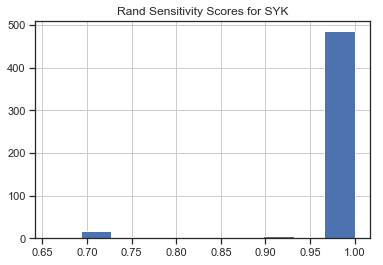

In [65]:
rand_syk = rand.loc['SYK']
print(rand_syk[rand_syk > 0].min())
print(rand_syk[rand_syk > 0].idxmin())

rand_syk[rand_syk > 0].hist()
plt.title('Rand Sensitivity Scores for SYK')
plt.show()

In [66]:
# check that it's not certain subclusters causing the issue
pd.DataFrame(rand.mean(axis=1)).merge(louv, left_index=True, right_index=True).groupby('cluster').agg(np.mean)

,0
cluster,
1,0.993683
2,0.991652
3,0.993499
4,0.991267
5,0.993664
6,0.994251
7,0.993390
8,0.993357
9,0.990403


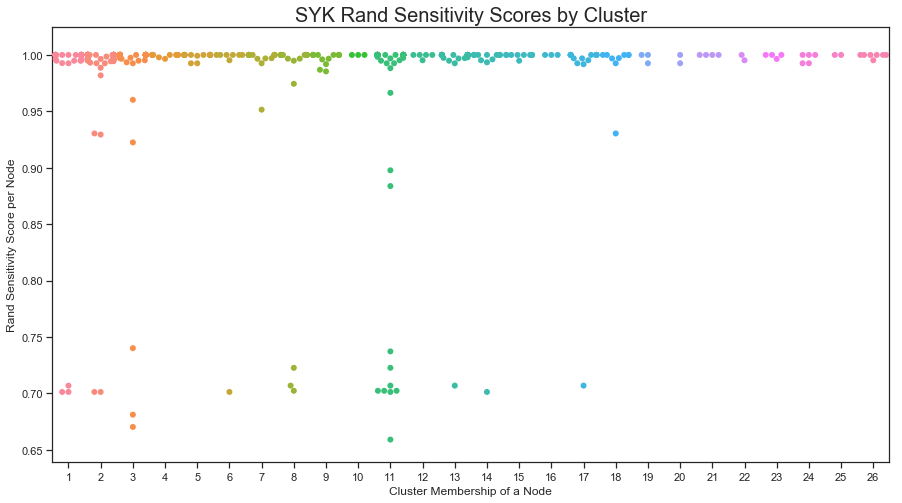

In [70]:
fig, ax = plt.subplots(figsize=(15,8))
sns.swarmplot(data=pd.DataFrame(rand_syk[rand_syk>0]).merge(louv, how='left', left_index=True, right_index=True), x='cluster', y='SYK', dodge=True, size=6, ax=ax)
plt.title('SYK Rand Sensitivity Scores by Cluster', fontsize=20)
plt.xlabel('Cluster Membership of a Node')
plt.ylabel('Rand Sensitivity Score per Node')
plt.show()

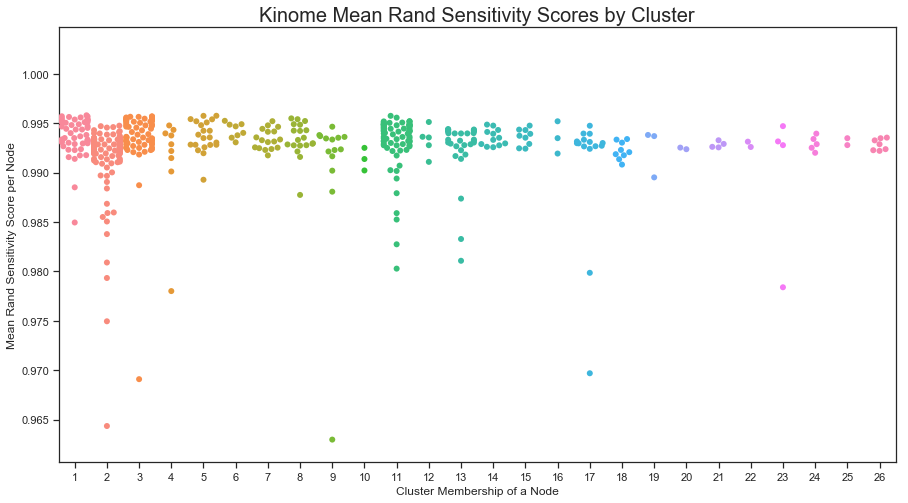

In [67]:
fig, ax = plt.subplots(figsize=(15,8))
sns.swarmplot(data=pd.DataFrame(rand.mean(axis=1)).merge(louv, left_index=True, right_index=True), x='cluster', y=0, dodge=True, size=6, ax=ax)
plt.title('Kinome Mean Rand Sensitivity Scores by Cluster', fontsize=20)
plt.xlabel('Cluster Membership of a Node')
plt.ylabel('Mean Rand Sensitivity Score per Node')
plt.show()

In [83]:
pd.DataFrame(rand_syk).merge(louv, how='left', left_index=True, right_index=True).groupby('cluster')['SYK'].agg('mean')

cluster
1     0.982079
2     0.993076
3     0.983204
4     0.999370
5     0.999259
6     0.962078
7     0.996157
8     0.952357
9     0.996915
10    1.000000
11    0.951185
12    0.999054
13    0.989798
14    0.973845
15    0.999429
16    1.000000
17    0.978702
18    0.990790
19    0.997531
20    0.996296
21    1.000000
22    0.997636
23    0.999110
24    0.997037
25    1.000000
26    0.999325
Name: SYK, dtype: float64

In [92]:
pd.DataFrame(rand_syk).merge(louv, how='left', left_index=True, right_index=True)[pd.DataFrame(rand_syk).merge(louv, how='left', left_index=True, right_index=True)['cluster']==1]

,SYK,cluster
PRKCD,0.996513,1
PRKCA,1.000000,1
PRKCB,0.706968,1
GSK3B,1.000000,1
PDPK1,0.701355,1
PRKCE,1.000000,1
PRKCG,1.000000,1
PRKCZ,1.000000,1
MARK2,1.000000,1
PRKCQ,1.000000,1


0.643825551988917
RPS6KA4


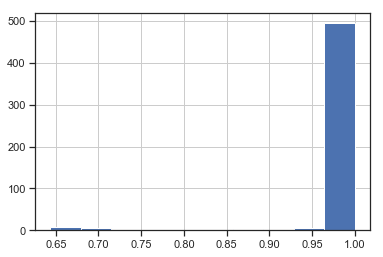

In [90]:
rand_lyn = rand.loc['LYN']
print(rand_lyn[rand_lyn > 0].min())
print(rand_lyn[rand_lyn > 0].idxmin())

rand_lyn[rand_lyn > 0].hist()
plt.show()

### Network Properties (needs to be moved)

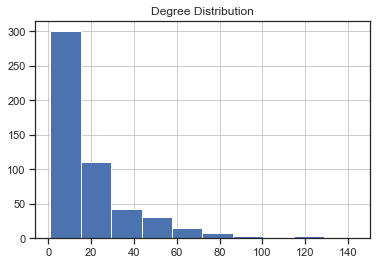

In [33]:
degree.hist()
plt.title('Degree Distribution')
plt.show()

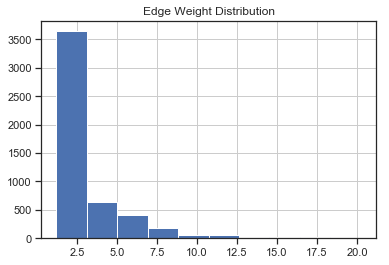

In [34]:
network[2].hist()
plt.title('Edge Weight Distribution')
plt.show()

In [45]:
network_rev = network.copy()
network_rev[1], network_rev[0] = (network_rev[0], network_rev[1])

agg_net = pd.DataFrame(pd.concat([network, network_rev], axis=0, ignore_index=True))

Text(0.5, 1.0, 'Distribution of Edge Weight Sums per Node')

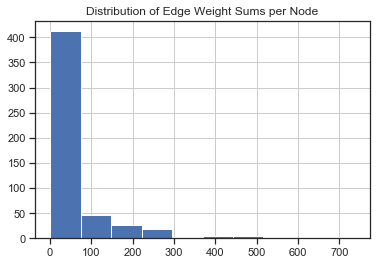

In [49]:
agg_net.groupby(1).agg(sum).hist()
plt.title('Distribution of Edge Weight Sums per Node')

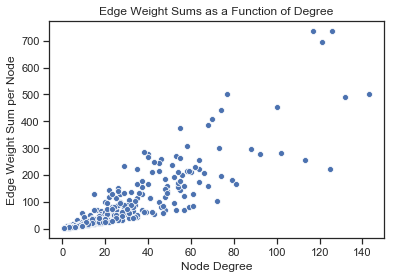

In [64]:
sns.scatterplot(x = degree.values[:, 0], y = agg_net.groupby(1).agg(sum).values[:, 0])
plt.title('Edge Weight Sums as a Function of Degree')
plt.xlabel('Node Degree')
plt.ylabel('Edge Weight Sum per Node')
plt.show()

In [66]:
import networkx as nx

In [68]:
network.columns = ['Source', 'Target', 'Weight']

In [71]:
g = nx.from_pandas_edgelist(network, source='Source', target='Target', edge_attr='Weight').to_undirected()


In [80]:
btwn = pd.DataFrame.from_dict(nx.betweenness_centrality(g), orient='index').sort_index()

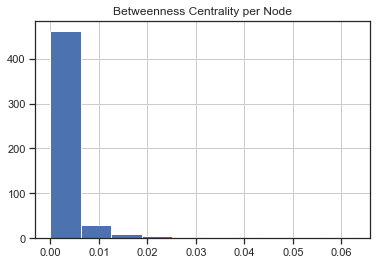

In [83]:
btwn.hist()
plt.title('Betweenness Centrality per Node')
plt.show()

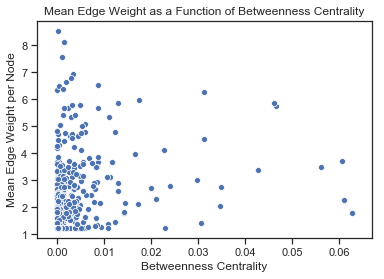

In [85]:
sns.scatterplot(x = btwn.values[:, 0], y = agg_net.groupby(1).agg(sum).values[:, 0]/degree.values[:, 0])
plt.title('Mean Edge Weight as a Function of Betweenness Centrality')
plt.xlabel('Betweenness Centrality')
plt.ylabel('Mean Edge Weight per Node')
plt.show()